**Identify fraudulent credit card transactions**

This is a classication problem with a highly uneven class distribution, i.e. fraudulent activity comprised only 0.17% of the dataset.  To enable better prediction, I (i) undersampled the majority class (legitimate transactions) to create a training set with equal representation from both classes; and (ii) created a test set with a class imbalance ratio similar to the problem scenario.  Predictor variables that are uncorrelated with class, as well as those that exhibit collinearity, were eliminated.

Compared to a no-skill benchmark created by dummy classifier, all four models showed considerable skill in identifying fraudulent credit card transactions.  In terms of area under precision recall curve and F1 score, K Neighbors Classifier had the best performance.  But it takes nearly two seconds to run, which can be problematic for customers looking to simply tap and go.  For a slightly reduced performance, the Random Forest Classifier takes less than one second and offers a more transparent, easier to explain decision path.  

Next step: try to reduce to number of false positives that could drive customers away.

Suggestions and advice are welcome!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['creditcard.csv']


In [2]:
#get tools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import discriminant_analysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix, roc_curve, roc_auc_score, classification_report, auc 


In [3]:
df=pd.read_csv('../input/creditcard.csv')
print(df.head(5))

   Time        V1        V2        V3  ...         V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...    0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ...   -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ...   -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...    0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...    0.219422  0.215153   69.99      0

[5 rows x 31 columns]


In [4]:
#Check for missing data
print(df.isnull().values.any())

False


In [5]:
#Great! Don't have any missing data.
#Get a summary
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
#Check the distribution of Fraud vs Legitimate transactions
FraudShare=round(df['Class'].value_counts()[1]/len(df)*100,2)
print(FraudShare,'% of transactions are fraudulent')

0.17 % of transactions are fraudulent


In [7]:
#Highly uneven distribution between classes
#Take a look at what fraudulent cases are like
df_temp=df.loc[df['Class']==1]
df_temp.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,-5.676883,3.800173,-6.259393,-0.109334,-6.971723,-0.092929,-4.139946,-6.665836,-2.246308,0.680659,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,4.897341,2.678605,4.654458,1.104518,4.278940,1.049915,3.865035,6.970618,2.899366,1.539853,1.346635,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,-1.702228,-18.683715,-3.127795,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-3.681904,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,-7.756698,1.973397,-8.688177,-0.979117,-9.692723,-0.643539,-6.562915,-11.945057,-4.664576,-0.299423,-0.171760,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,-4.578825,3.586218,-5.502530,-0.065566,-6.729720,-0.057227,-3.549795,-5.302949,-1.664346,0.646807,0.284693,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,-2.614184,5.307078,-2.974088,0.672964,-4.282821,0.609189,-1.226043,-1.341940,0.091772,1.649318,0.822445,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,4.031435,12.018913,1.375941,2.815440,3.442422,2.471358,3.139656,6.739384,3.790316,5.228342,11.059004,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


In [8]:
#Only 492 fraudulent transactions
#Average fraudulent amount swiped $122
#Half of fraudulent transactions are for amounts less than $10

#Ideally, split data into train and test sets first
#Then run PCA and standardization on train set to avoid information leak
#But host data already has PCA run on V variables over entire data set
#So standardize Amount and Time to "jive"

sc=StandardScaler()
df['Amount_scaled']=sc.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time_scaled']=sc.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'],axis=1,inplace=True)
print(df.head(3))

         V1        V2        V3     ...       Class  Amount_scaled  Time_scaled
0 -1.359807 -0.072781  2.536347     ...           0       0.244964    -1.996583
1  1.191857  0.266151  0.166480     ...           0      -0.342475    -1.996583
2 -1.358354 -1.340163  1.773209     ...           0       1.160686    -1.996562

[3 rows x 31 columns]


In [9]:
#Given the highly uneven distribution between classes, need
#(1) a training set with an even distribution of both classes; and
#(2) an unseen test set with a majority to minority class distribution similar to original dataset

#Random undersample the majority class for 1:1 distribution
#First shuffle the data (argument 'frac' specifies fraction of rows to return in random sample)
df.sample(frac=1)

#From description of Fraud set, we know we have 492 Fraud cases
#Get 492 Non-fraud cases from randomly shuffled set
df_Norm=df.loc[df['Class']==0][:492]
df_Fraud=df.loc[df['Class']==1]

#Join dfFraud and dfNorm to get a normally distributed df
df_norm_dist=pd.concat([df_Norm,df_Fraud])

#Shuffle dataframe rows
df_New=df_norm_dist.sample(frac=1,random_state=22)

#Get required non-fraud cases for test set
df_NormUp=df.loc[df['Class']==0][493:58000]

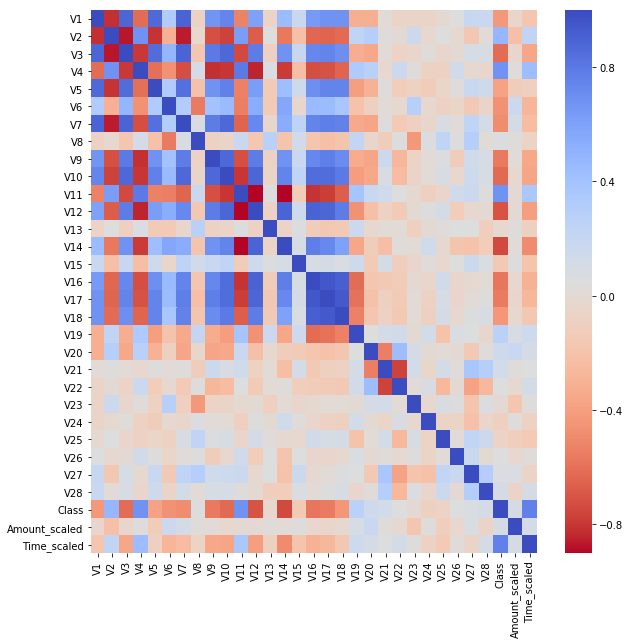

In [10]:
#We don't know what the 'V' variables are and how they affect 'Class'
#How are variables correlated?
#Can we remove non-supporting ones for more parsimonious model?

sub_sample_corr=df_New.corr()
plt.figure(figsize=(10,10))
sns.heatmap(sub_sample_corr,cmap='coolwarm_r')

In [11]:
#Drop uncorrelated, non-supporting variables from the training features
df_New.drop(['V8','V13','V23','V26','V27','V28','Amount_scaled'],axis=1,inplace=True)
print(df_New.head(3))

              V1        V2        V3     ...            V25  Class  Time_scaled
79874  -0.443794  1.271395  1.206178     ...       0.029516      1    -0.770654
94      1.212511 -0.099054 -1.192094     ...       0.883548      0    -1.995235
123270  1.082566  1.094862 -1.367020     ...       0.569167      1    -0.377924

[3 rows x 24 columns]


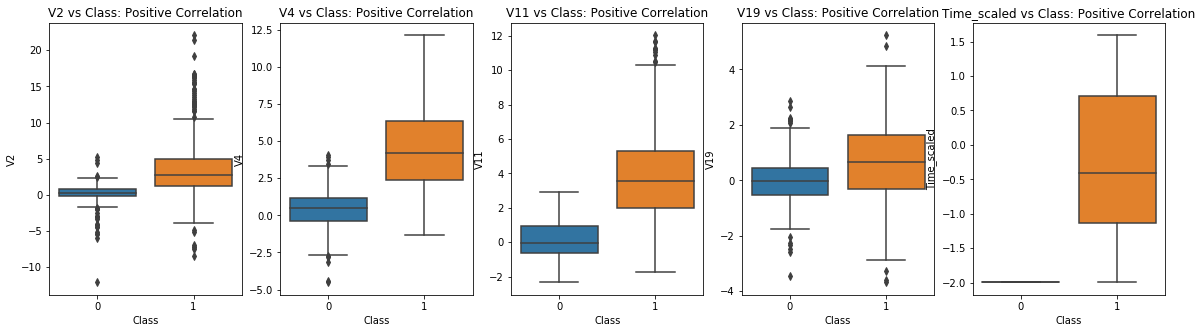

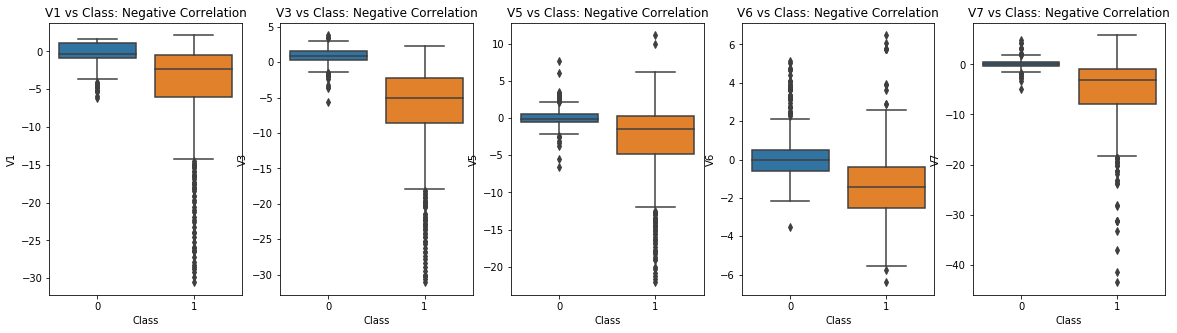

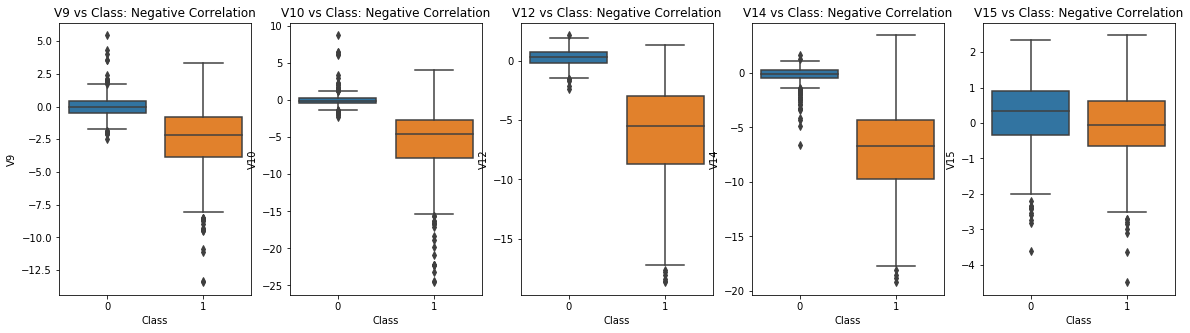

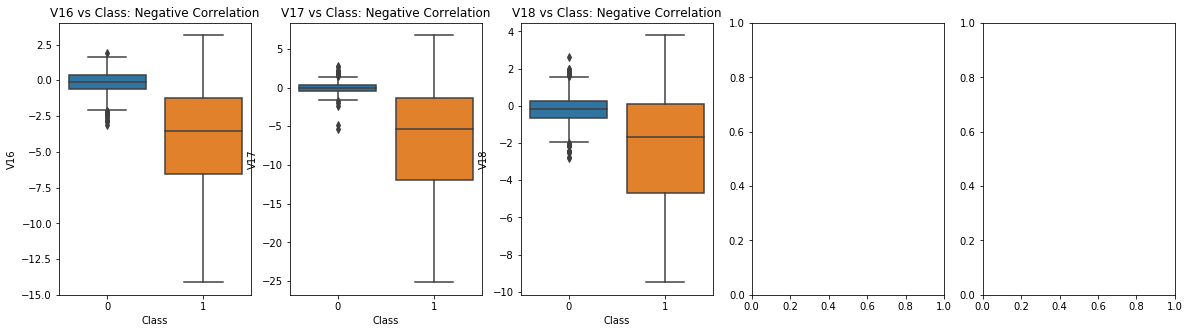

In [12]:
#Identifying fraud vs. non-fraud cases is a classification problem
#Need to check for extreme outliers in supporting variables
#Plot box and whisker charts to see

#Variables with positive correlation with class
#V2,V4,V11,V19,Time_scaled
f,axes=plt.subplots(ncols=5,figsize=(20,5))

sns.boxplot(x='Class',y='V2',data=df_New,ax=axes[0])
axes[0].set_title('V2 vs Class: Positive Correlation')

sns.boxplot(x='Class',y='V4',data=df_New,ax=axes[1])
axes[1].set_title('V4 vs Class: Positive Correlation')
            
sns.boxplot(x='Class',y='V11',data=df_New,ax=axes[2])
axes[2].set_title('V11 vs Class: Positive Correlation')

sns.boxplot(x='Class',y='V19',data=df_New,ax=axes[3])
axes[3].set_title('V19 vs Class: Positive Correlation')

sns.boxplot(x='Class',y='Time_scaled',data=df_New,ax=axes[4])
axes[4].set_title('Time_scaled vs Class: Positive Correlation')

plt.show()

#Variables with negative correlation with class
#V1,V3,V5,V6,V7,V9,V10,V12,V14,V15,V16,V17,V18
f,axes=plt.subplots(ncols=5,figsize=(20,5))

sns.boxplot(x='Class',y='V1',data=df_New,ax=axes[0])
axes[0].set_title('V1 vs Class: Negative Correlation')

sns.boxplot(x='Class',y='V3',data=df_New,ax=axes[1])
axes[1].set_title('V3 vs Class: Negative Correlation')

sns.boxplot(x='Class',y='V5',data=df_New,ax=axes[2])
axes[2].set_title('V5 vs Class: Negative Correlation')

sns.boxplot(x='Class',y='V6',data=df_New,ax=axes[3])
axes[3].set_title('V6 vs Class: Negative Correlation')

sns.boxplot(x='Class',y='V7',data=df_New,ax=axes[4])
axes[4].set_title('V7 vs Class: Negative Correlation')

plt.show()

f,axes=plt.subplots(ncols=5,figsize=(20,5))
sns.boxplot(x='Class',y='V9',data=df_New,ax=axes[0])
axes[0].set_title('V9 vs Class: Negative Correlation')

sns.boxplot(x='Class',y='V10',data=df_New,ax=axes[1])
axes[1].set_title('V10 vs Class: Negative Correlation')

sns.boxplot(x='Class',y='V12',data=df_New,ax=axes[2])
axes[2].set_title('V12 vs Class: Negative Correlation')

sns.boxplot(x='Class',y='V14',data=df_New,ax=axes[3])
axes[3].set_title('V14 vs Class: Negative Correlation')

sns.boxplot(x='Class',y='V15',data=df_New,ax=axes[4])
axes[4].set_title('V15 vs Class: Negative Correlation')

plt.show()

f,axes=plt.subplots(ncols=5,figsize=(20,5))

sns.boxplot(x='Class',y='V16',data=df_New,ax=axes[0])
axes[0].set_title('V16 vs Class: Negative Correlation')

sns.boxplot(x='Class',y='V17',data=df_New,ax=axes[1])
axes[1].set_title('V17 vs Class: Negative Correlation')

sns.boxplot(x='Class',y='V18',data=df_New,ax=axes[2])
axes[2].set_title('V18 vs Class: Negative Correlation')

plt.show()

In [13]:
#Get rid of variables with collinearity
#Keep an edited set of predictors with fewer outliers
df_New.drop(['V2','V3','V5','V7','V9','V11','V15','V19','V20','V21','V22','V24','V25','Time_scaled'],axis=1,inplace=True)
df_New.head()

,V1,V4,V6,V10,V12,V14,V16,V17,V18,Class
79874,-0.443794,0.790371,-0.848376,-0.867900,-0.657948,-1.635145,0.068533,1.325794,0.376383,1
94,1.212511,0.286324,3.616314,-0.030522,0.237212,0.197437,-0.097830,-0.510053,-0.070939,0
123270,1.082566,2.012554,-0.807712,-1.925278,-0.309219,-4.429195,1.055514,3.970587,1.762249,1
436,-1.038356,0.988402,-0.378862,-0.346582,-0.999027,1.049902,-0.372647,0.350350,-0.035845,0
198868,0.432554,2.448080,-2.979912,-2.314747,-0.407550,-5.871438,1.679873,5.540865,3.207637,1


In [14]:
#Trim off extreme outliers in predictor variables
#Start with a larger value since don't have a lot of data to work with
#Using a smaller value, e.g. 2.5, might lose too much information

#V1
V1_fraud=df_New['V1'].loc[df_New['Class']==1].values
q_25,q_75=np.percentile(V1_fraud,25),np.percentile(V1_fraud,75)
#Get interquartile range
V1_fraud_iqr=q_75-q_25
#Set cut-off at 2 times interquartile range
V1_fraud_cutoff=V1_fraud_iqr*4.25
V1_fraud_low,V1_fraud_high=q_25-V1_fraud_cutoff,q_75+V1_fraud_cutoff
df_New=df_New.drop(df_New[(df_New['V1'] > V1_fraud_high) | (df_New['V1'] < V1_fraud_low)].index)

#V6
V6_fraud=df_New['V6'].loc[df_New['Class']==1].values
q_25,q_75=np.percentile(V6_fraud,25),np.percentile(V6_fraud,75)
V6_fraud_iqr=q_75-q_25
V6_fraud_cutoff=V6_fraud_iqr*4.25
V6_fraud_low,V6_fraud_high=q_25-V6_fraud_cutoff,q_75+V6_fraud_cutoff
df_New=df_New.drop(df_New[(df_New['V6'] > V6_fraud_high) | (df_New['V6'] < V6_fraud_low)].index)


#V10
V10_fraud=df_New['V10'].loc[df_New['Class']==1].values
q_25,q_75=np.percentile(V10_fraud,25),np.percentile(V10_fraud,75)
V10_fraud_iqr=q_75-q_25
V10_fraud_cutoff=V10_fraud_iqr*4.25
V10_fraud_low,V10_fraud_high=q_25-V10_fraud_cutoff,q_75+V10_fraud_cutoff
df_New=df_New.drop(df_New[(df_New['V10'] > V10_fraud_high) | (df_New['V10'] < V10_fraud_low)].index)

#V12
V12_fraud=df_New['V12'].loc[df_New['Class']==1].values
q_25,q_75=np.percentile(V12_fraud,25),np.percentile(V12_fraud,75)
V12_fraud_iqr=q_75-q_25
V12_fraud_cutoff=V12_fraud_iqr*4.25
V12_fraud_low,V12_fraud_high=q_25-V12_fraud_cutoff,q_75+V12_fraud_cutoff
df_New=df_New.drop(df_New[(df_New['V12'] > V12_fraud_high) | (df_New['V12'] < V12_fraud_low)].index)

#V14
V14_fraud=df_New['V14'].loc[df_New['Class']==1].values
q_25,q_75=np.percentile(V14_fraud,25),np.percentile(V14_fraud,75)
V14_fraud_iqr=q_75-q_25
V14_fraud_cutoff=V14_fraud_iqr*4.25
V14_fraud_low,V14_fraud_high=q_25-V14_fraud_cutoff,q_75+V14_fraud_cutoff
df_New=df_New.drop(df_New[(df_New['V14'] > V14_fraud_high) | (df_New['V14'] < V14_fraud_low)].index)


In [15]:
#Split into training and test sets first.
X=df_New.drop(labels='Class',axis=1) #features
Y=df_New.loc[:,'Class'] #response

X_train, X_test, Y_train, Y_test=train_test_split(X, Y, test_size=0.2, random_state=22)


In [16]:
#Remember to prep a test set with uneven distribution of classes
#Minority class represented only 0.17% of original
#Therefore, we need to upsample the majority class in the test set
df_NormUp.drop(['V8','V13','V23','V26','V27','V28','Amount_scaled'],axis=1,inplace=True)
df_NormUp.drop(['V2','V3','V5','V7','V9','V11','V15','V19','V20','V21','V22','V24','V25','Time_scaled'],axis=1,inplace=True)
x=df_NormUp.drop(labels='Class',axis=1)
y=df_NormUp.loc[:,'Class']

testx=pd.concat([X_test,x])
testy=pd.concat([Y_test,y])


In [17]:
#Let's fit a dummy classifier to use as a no-skill benchmark

from sklearn.dummy import DummyClassifier
DUM_mod=DummyClassifier(random_state=22)
DUM_mod.fit(X_train,Y_train)
Y_pred_DUM=DUM_mod.predict(testx)


In [18]:
#Fit K Neighbors Classifier, QDA, Logit, and Random Forest Classifier models to data
#Time estimation process

KNC_mod=KNeighborsClassifier()
QDA_mod=discriminant_analysis.QuadraticDiscriminantAnalysis()
LOG_mod=LogisticRegression()
RFC_mod=RandomForestClassifier(max_depth=4,random_state=22)

t0_est=time.time()

KNC_mod.fit(X_train,Y_train)
QDA_mod.fit(X_train,Y_train)
LOG_mod.fit(X_train,Y_train)
RFC_mod.fit(X_train,Y_train)

t1_est=time.time()
print('Estimation of all four models took: {0:.4f} seconds'.format(t1_est-t0_est))

Estimation of all four models took: 0.0650 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
#Predict using test sample
#Time process to see how long each takes

t0_KNC=time.time()
Y_pred_KNC=KNC_mod.predict(testx)
t1_KNC=time.time()
print("Predicting with K Neighbors Classifier model took: {0:.4f} seconds".format(t1_KNC-t0_KNC))

t0_QDA=time.time()
Y_pred_QDA=QDA_mod.predict(testx)
t1_QDA=time.time()
print("Predicting with QDA model took: {0:.4f} seconds".format(t1_QDA-t0_QDA))

t0_LOG=time.time()
Y_pred_LOG=LOG_mod.predict(testx)
t1_LOG=time.time()
print("Predicting with Logistic Classification model took: {0:.4f} seconds".format(t1_LOG-t0_LOG))

t0_RFC=time.time()
Y_pred_RFC=RFC_mod.predict(testx)
t1_RFC=time.time()
print("Predicting with Random Forest Classifier model took: {0:.4f} seconds".format(t1_RFC-t0_RFC))

Predicting with K Neighbors Classifier model took: 1.9467 seconds
Predicting with QDA model took: 0.0154 seconds
Predicting with Logistic Classification model took: 0.0025 seconds
Predicting with Random Forest Classifier model took: 0.0380 seconds


In [20]:
#Plot precision recall curve

#Calculate precision recall curves
precision_DUM,recall_DUM,threshold_DUM=precision_recall_curve(testy,Y_pred_DUM)
precision_KNC,recall_KNC,threshold_KNC=precision_recall_curve(testy,Y_pred_KNC)
precision_QDA,recall_QDA,threshold_QDA=precision_recall_curve(testy,Y_pred_QDA)
precision_LOG,recall_LOG,threshold_LOG=precision_recall_curve(testy,Y_pred_LOG)
precision_RFC,recall_RFC,threshold_RFC=precision_recall_curve(testy,Y_pred_RFC)

#Calculate area under precision recall curves
auprc_DUM=auc(recall_DUM,precision_DUM)
auprc_KNC=auc(recall_KNC,precision_KNC)
auprc_QDA=auc(recall_QDA,precision_QDA)
auprc_LOG=auc(recall_LOG,precision_LOG)
auprc_RFC=auc(recall_RFC,precision_RFC)

print ("Area under precision recall curve, Dummy Classifier model: {0:.4f}".format(auprc_DUM))
print ("Area under precision recall curve, K Neighbors Classification model: {0:.4f}".format(auprc_KNC))
print ("Area under precision recall curve, QDA model: {0:.4f}".format(auprc_QDA))
print ("Area under precision recall curve, Logistic Classification model: {0:.4f}".format(auprc_LOG))
print ("Area under precision recall curve, Random Forest Classification model: {0:.4f}".format(auprc_RFC))

Area under precision recall curve, Dummy Classifier model: 0.2538
Area under precision recall curve, K Neighbors Classification model: 0.4924
Area under precision recall curve, QDA model: 0.4761
Area under precision recall curve, Logistic Classification model: 0.4816
Area under precision recall curve, Random Forest Classification model: 0.4819


In [21]:
#Hmm, all have AUPRC<0.5 but outperform dummy classifier

#Check Precision Recall Score
AP_DUM=average_precision_score(testy,Y_pred_DUM)
AP_KNC=average_precision_score(testy,Y_pred_KNC)
AP_QDA=average_precision_score(testy,Y_pred_QDA)
AP_LOG=average_precision_score(testy,Y_pred_LOG)
AP_RFC=average_precision_score(testy,Y_pred_RFC)

print('Average Precision Score, DUM model: {0:.4f}'.format(AP_DUM))
print('Average Precision Score, KNC model: {0:.4f}'.format(AP_KNC))
print('Average Precision Score, QDA model: {0:.4f}'.format(AP_QDA))
print('Average Precision Score, LOG model: {0:.4f}'.format(AP_LOG))
print('Average Precision Score, RFC model: {0:.4f}'.format(AP_RFC))

Average Precision Score, DUM model: 0.0018
Average Precision Score, KNC model: 0.0491
Average Precision Score, QDA model: 0.0099
Average Precision Score, LOG model: 0.0112
Average Precision Score, RFC model: 0.0208


In [22]:
#Not great. But show some skill relative to the dummy model

#Make a classification report for each model
labels=['No Fraud','Fraud']
print('--'*30)
print('Dummy Classification Model')
print('--'*30)
print(classification_report(testy,Y_pred_DUM,target_names=labels))
print('--'*30)
print('K Neighbors Classification Model')
print('--'*30)
print(classification_report(testy,Y_pred_KNC,target_names=labels))
print('--'*30)
print('Quadratic Discriminant Analysis Model')
print('--'*30)
print(classification_report(testy,Y_pred_QDA,target_names=labels))
print('--'*30)
print('Logistic Regression Model')
print('--'*30)
print(classification_report(testy,Y_pred_LOG,target_names=labels))
print('--'*30)
print('Random Forest Classifier Model')
print('--'*30)
print(classification_report(testy,Y_pred_RFC,target_names=labels))
print('--'*30)

------------------------------------------------------------
Dummy Classification Model
------------------------------------------------------------
              precision    recall  f1-score   support

    No Fraud       1.00      0.51      0.67     57601
       Fraud       0.00      0.50      0.00       103

    accuracy                           0.51     57704
   macro avg       0.50      0.50      0.34     57704
weighted avg       1.00      0.51      0.67     57704

------------------------------------------------------------
K Neighbors Classification Model
------------------------------------------------------------
              precision    recall  f1-score   support

    No Fraud       1.00      0.97      0.98     57601
       Fraud       0.05      0.93      0.10       103

    accuracy                           0.97     57704
   macro avg       0.53      0.95      0.54     57704
weighted avg       1.00      0.97      0.98     57704

------------------------------------------

In [23]:
print(confusion_matrix(testy,Y_pred_DUM))
print(confusion_matrix(testy,Y_pred_KNC))
print(confusion_matrix(testy,Y_pred_QDA))
print(confusion_matrix(testy,Y_pred_LOG))
print(confusion_matrix(testy,Y_pred_RFC))

[[29092 28509]
 [   51    52]]
[[55870  1731]
 [    7    96]]
[[48411  9190]
 [    6    97]]
[[49336  8265]
 [    5    98]]
[[53287  4314]
 [    6    97]]


In terms of area under precision recall curve and f1 score, K Neighbors Classification model has the best performance among the models tried.  But, the area under precision recall curve for this model is still under 0.5. Also, it takes nearly 2 seconds to predict, which might annoy customers trying to pay and go ASAP.  Random Forest Classification model could be a better choice but there are still quite a large number of false positives that could annoy and drive away customers. 